##### Copyright 2019 The TensorFlow Authors.

In [39]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections: 

* Forecast for a single time step:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

## Setup

In [40]:
%matplotlib inline

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from pathlib import Path

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

np.random.seed(42)
tf.random.set_seed(42)

In [41]:
plt.rcParams['figure.dpi'] = 300
sns.set_style('whitegrid')

In [42]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [43]:
!nvidia-smi

Wed Jul  6 13:50:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| 30%   58C    P8    18W / 200W |   1937MiB /  4096MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [44]:
lstm_units = 63

## Load Data

In [45]:
csv_path = "/app/StockPricePredictions/data/alphavantage/time_series_daily_adjusted/AAPL/AAPL_WITH_BENZINGA_FINBERT_SA.csv"

...

In [46]:
df = pd.read_csv(csv_path)
df.sort_values(by=["date"], ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

date_time = pd.to_datetime(df.pop('date'))

df = df[["5. adjusted close"]] 


...

In [47]:
df.head()

,5. adjusted close
0,6.543876
1,6.555190
2,6.450921
3,6.438996
4,6.481804


Here is the evolution of a few features over time:

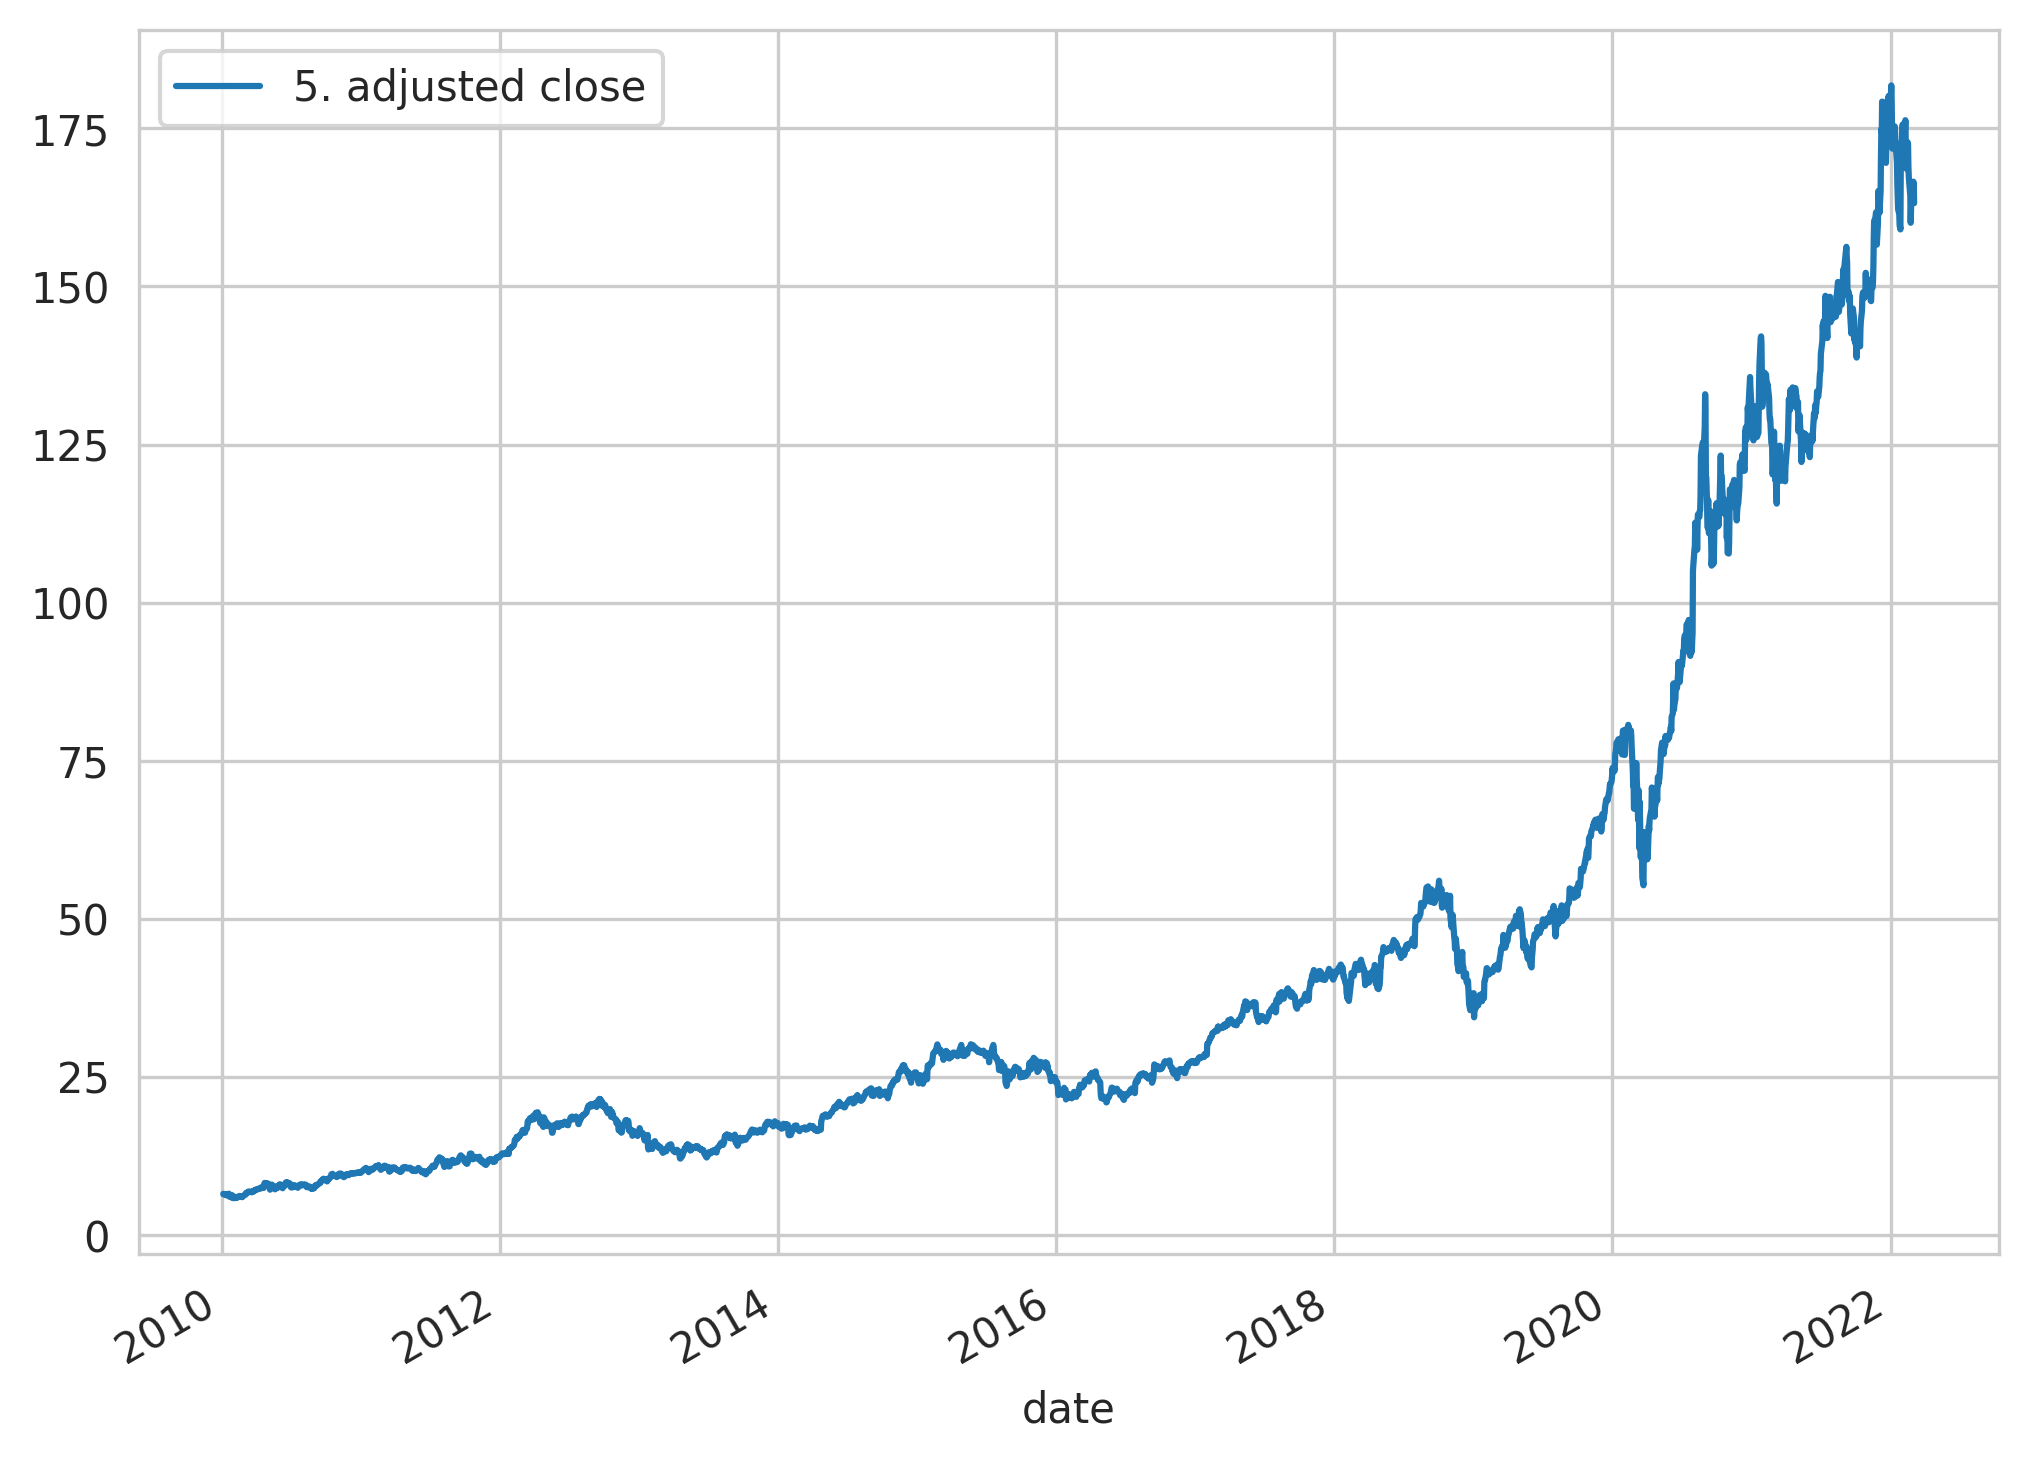

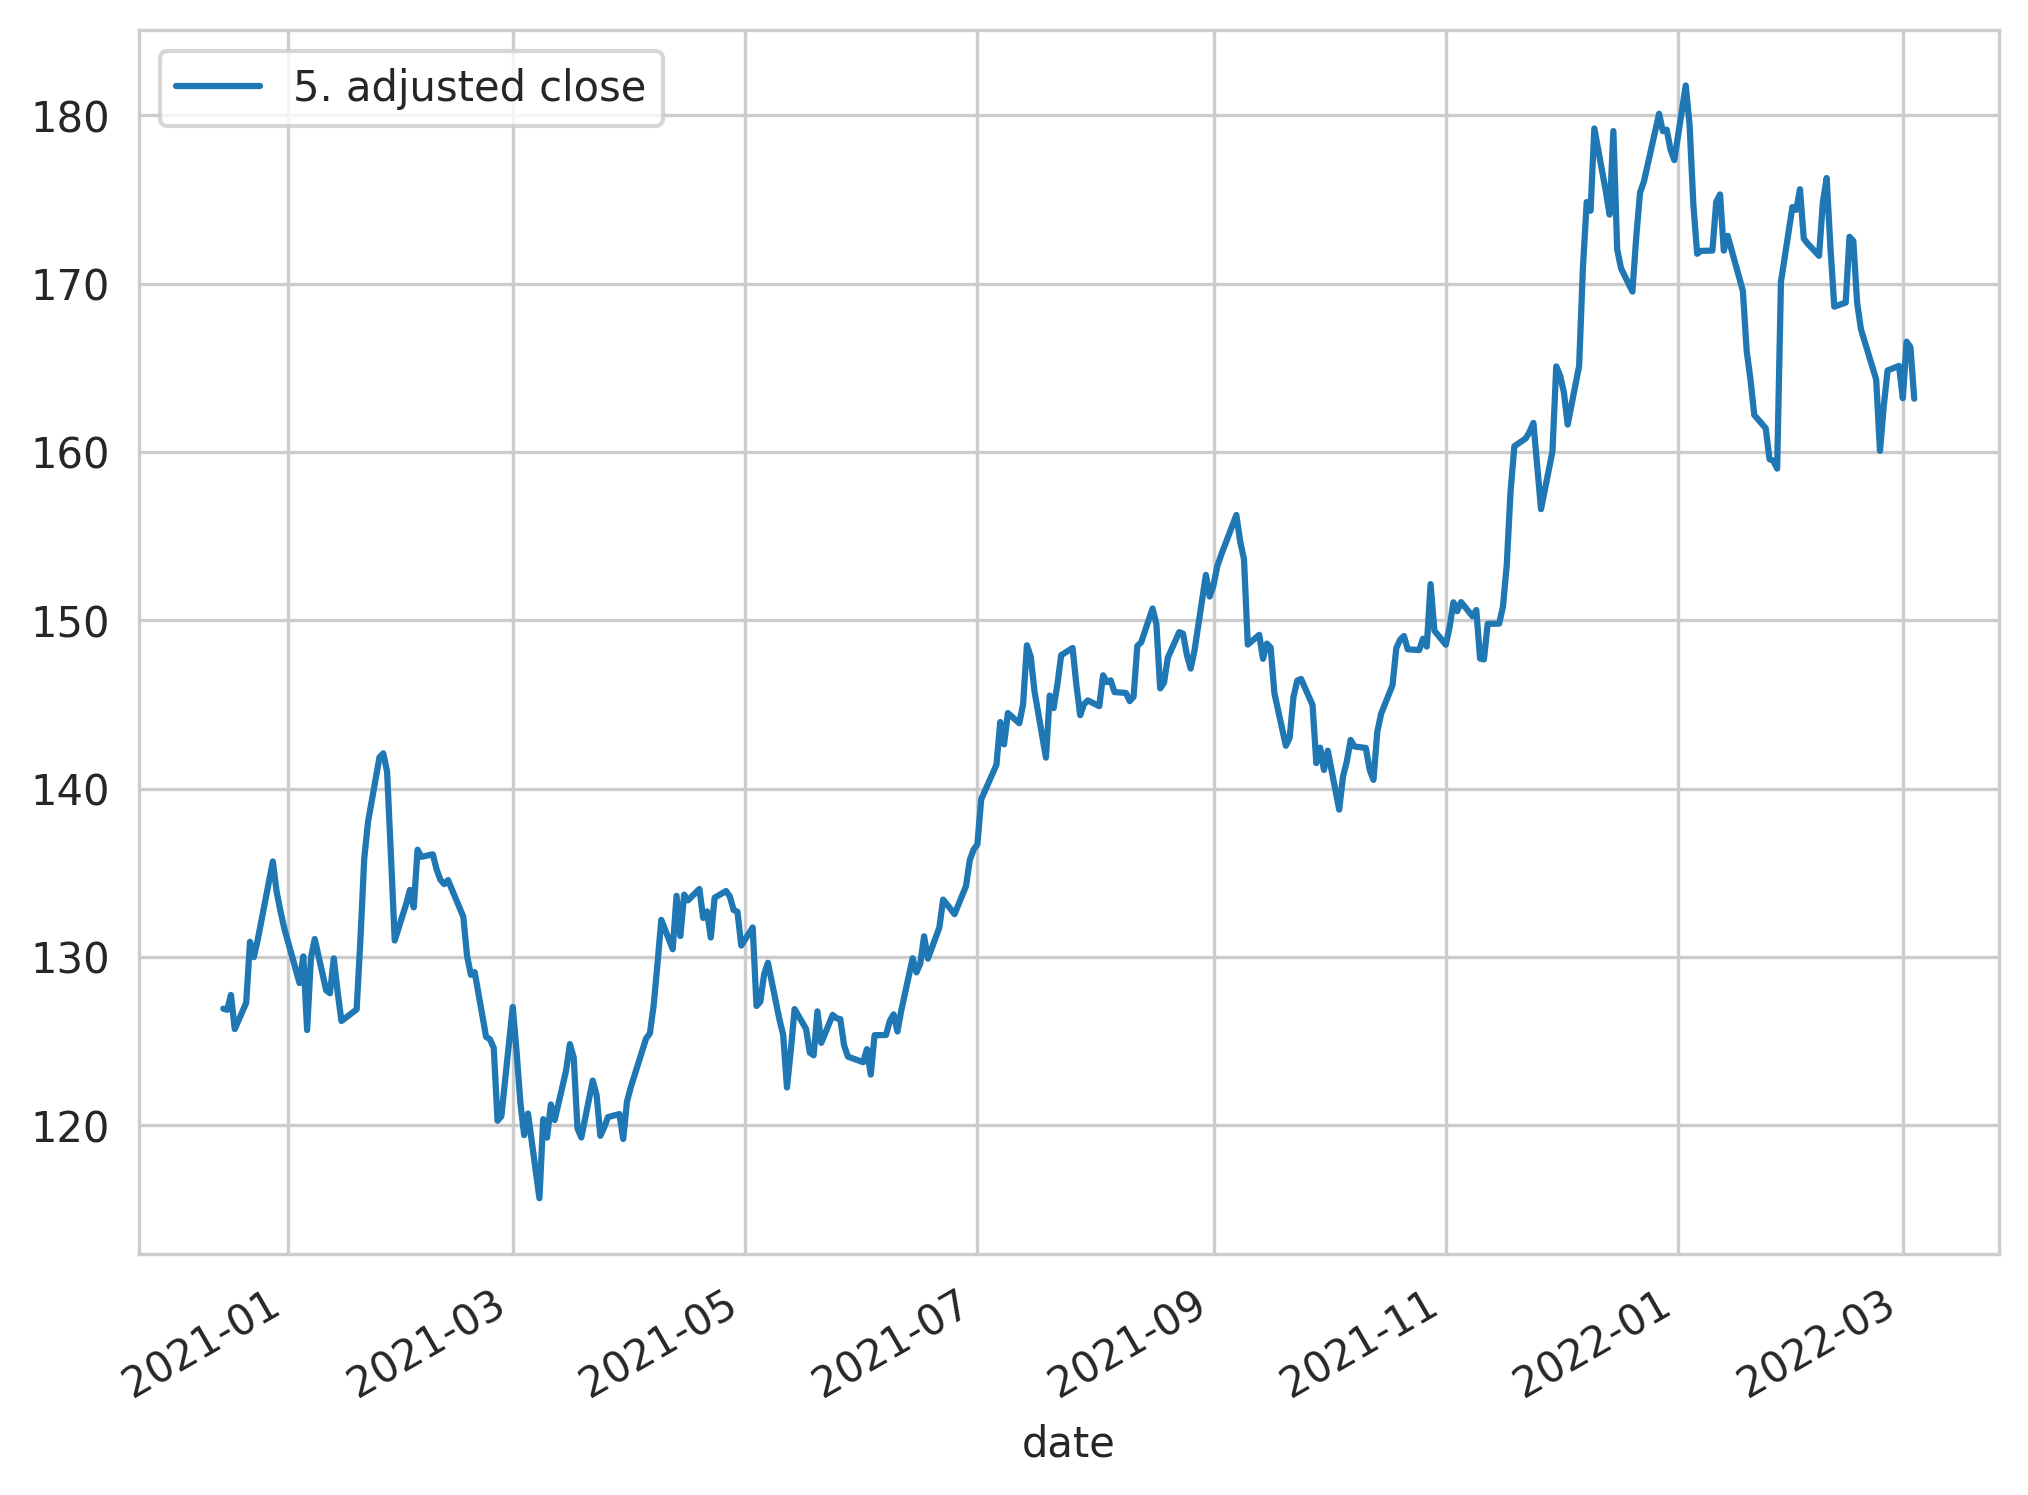

In [48]:
# plot_cols = ['1. open', '2. high', '3. low', '4. close', '5. adjusted close', '6. volume']
plot_cols = ['5. adjusted close']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][2757:]
plot_features.index = date_time[2757:]
_ = plot_features.plot(subplots=True)

Statistics

In [49]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
5. adjusted close,3064.0,42.73636,41.154337,5.872396,16.285903,26.270965,48.589739,181.778019


### Split the data

You'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [50]:
column_indices = {name: i for i, name in enumerate(df.columns)}

split_time = int(len(df) * .9)

train_df = df[:split_time+63]
test_df = df[split_time+63:]

print(len(train_df))
print(len(test_df))

2820
244


### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So, in the interest of simplicity this tutorial uses a simple average.

In [51]:
# train_mean = train_df.mean()
# train_std = train_df.std()

# train_df = (train_df - train_mean) / train_std
# val_df = (val_df - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std


from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# scaled_features = scaler.fit_transform(train_df.values)
# train_df_scaled = pd.DataFrame(scaled_features, index=train_df.index, columns=train_df.columns)
train_df_scaled = train_df.copy() #  pd.DataFrame(scaled_features, index=train_df.index, columns=train_df.columns)
# scaled_features = scaler.transform(test_df.values)
# test_df_scaled = pd.DataFrame(scaled_features, index=test_df.index, columns=test_df.columns)
test_df_scaled = test_df.copy() # pd.DataFrame(scaled_features, index=test_df.index, columns=test_df.columns)

Now, peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

- *Single-output*, and *multi-output* predictions.
- *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:

  ![One prediction 24 hours into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2. A model that makes a prediction one hour into the future, given six hours of history, would need a window like this:

  ![One prediction one hour into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to `tf.data.Dataset`s of windows later.

In [52]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               # train_df=train_df, val_df=val_df, test_df=test_df,
               train_df=train_df_scaled, test_df=test_df_scaled,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df_scaled
    # self.val_df = val_df
    self.test_df = test_df_scaled

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [53]:
w1 = WindowGenerator(input_width=lstm_units, label_width=1, shift=24,
                     label_columns=['5. adjusted close'])
w1

Total window size: 87
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62]
Label indices: [86]
Label column name(s): ['5. adjusted close']

In [54]:
w2 = WindowGenerator(input_width=lstm_units, label_width=1, shift=1,
                     label_columns=['5. adjusted close'])
w2

Total window size: 64
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62]
Label indices: [63]
Label column name(s): ['5. adjusted close']

### 2. Split

Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2` you define earlier will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/split_window.png?raw=1)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [55]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out:

In [56]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 64, 1)
Inputs shape: (3, 63, 1)
Labels shape: (3, 1, 1)


Typically, data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of three 7-time step windows with 19 features at each time step. It splits them into a batch of 6-time step 19-feature inputs, and a 1-time step 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['T (degC)']`. Initially, this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [57]:
w2.example = example_inputs, example_labels

In [58]:
def plot(self, model=None, plot_col='5. adjusted close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

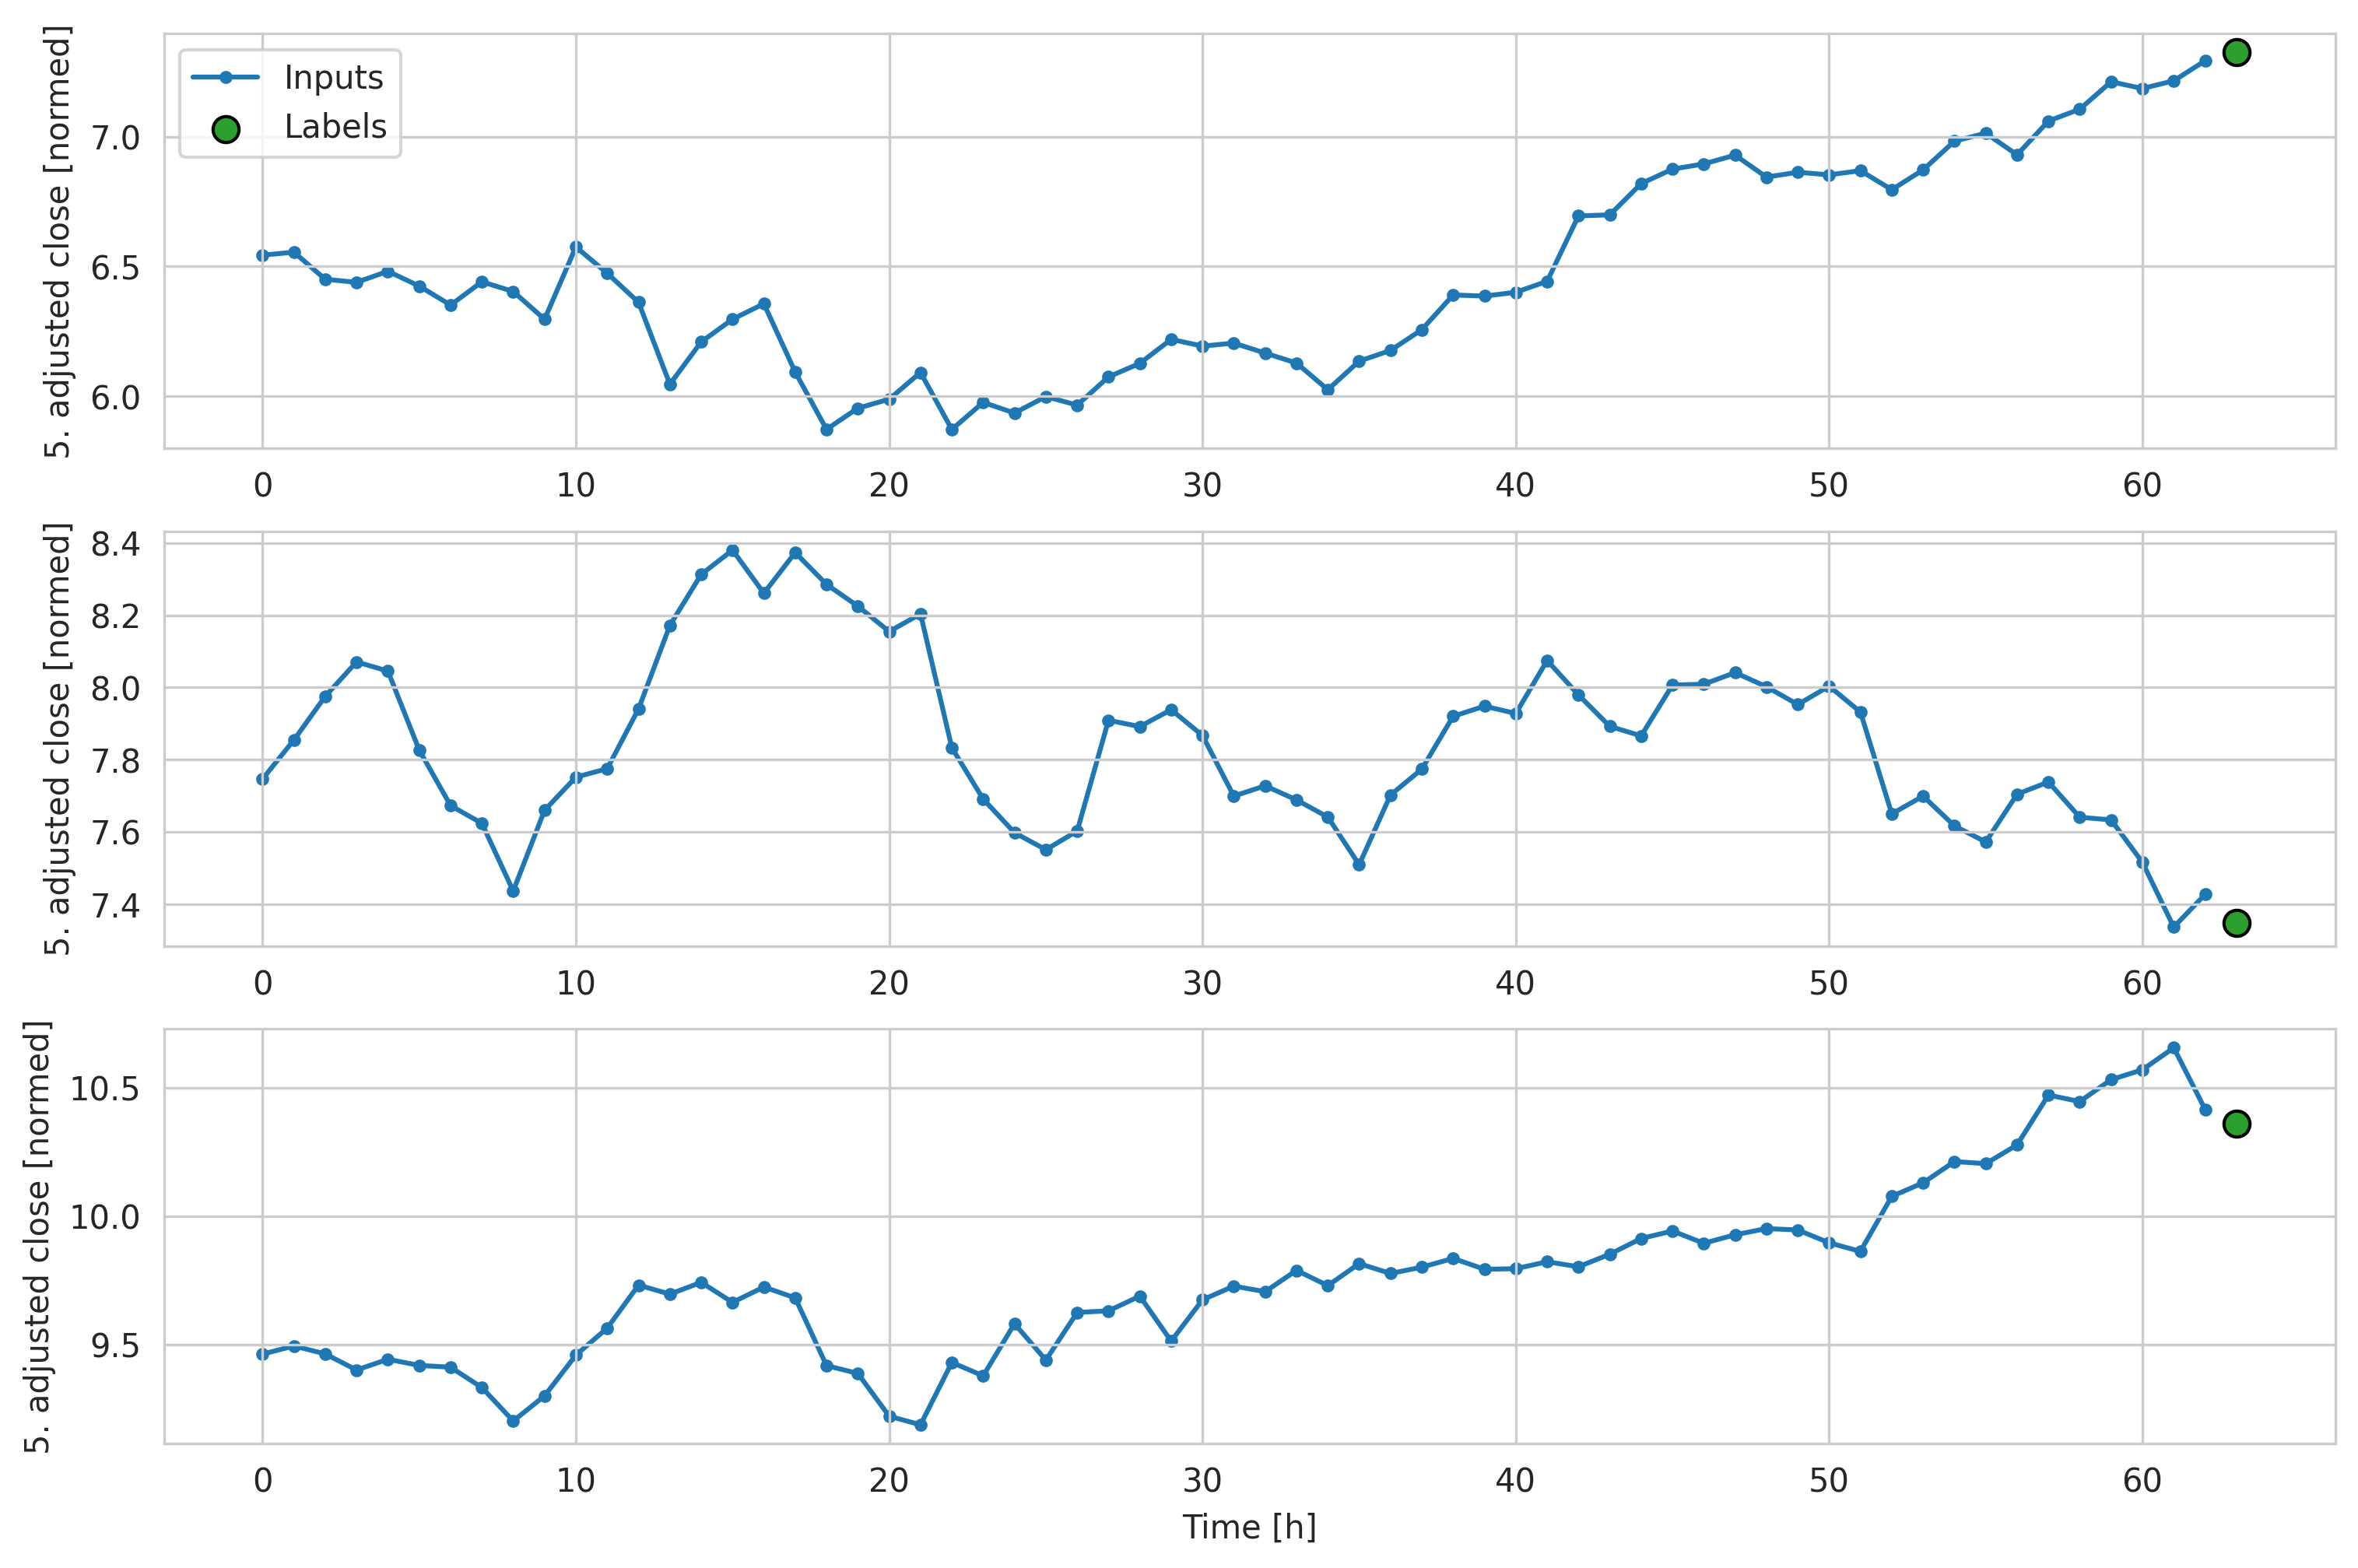

In [59]:
w2.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `T (degC)` column.

In [60]:
# w2.plot(plot_col='p (mbar)')

### 4. Create `tf.data.Dataset`s

Finally, this `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `tf.keras.utils.timeseries_dataset_from_array` function:

In [61]:
shuffle_ds = True

In [62]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=shuffle_ds,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation, and test data.

Add properties for accessing them as `tf.data.Dataset`s using the `make_dataset` method you defined earlier. Also, add a standard example batch for easy access and plotting:

In [63]:
@property
def train(self):
  return self.make_dataset(self.train_df)

# @property
# def val(self):
#   return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
# WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now, the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, data types, and shapes of the dataset elements.

In [64]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 63, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [65]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 63, 1)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value—1 time step (one hour) into the future based only on the current conditions.

So, start by building models to predict the `T (degC)` value one hour into the future.

![Predict the next time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [66]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['5. adjusted close'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['5. adjusted close']

The `window` object creates `tf.data.Dataset`s from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [67]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 1)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature one hour into the future, given the current value of all features. The current values include the current temperature. 

So, start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/baseline.png?raw=1)

In [68]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [69]:
baseline = Baseline(label_index=column_indices['5. adjusted close'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])


train_performance = {}
test_performance = {}

train_performance['Baseline'] = baseline.evaluate(single_step_window.train, verbose=0)
test_performance['Baseline'] = baseline.evaluate(single_step_window.test)

8/8 [==============================] - 0s 4ms/step - loss: 5.0998 - mean_absolute_error: 1.7012


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample.

So, create a wider `WindowGenerator` that generates windows 24 hours of consecutive inputs and labels at a time. The new `wide_window` variable doesn't change the way the model operates. The model still makes predictions one hour into the future based on a single input time step. Here, the `time` axis acts like the `batch` axis: each prediction is made independently with no interaction between time steps:

In [70]:
wide_window = WindowGenerator(
    input_width=lstm_units, label_width=lstm_units, shift=1,
    label_columns=['5. adjusted close'])

wide_window

Total window size: 64
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Label column name(s): ['5. adjusted close']

This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of time steps, and the baseline just forwards the input to the output:

![One prediction 1h into the future, ever hour.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/last_window.png?raw=1)

In [71]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 63, 1)
Output shape: (32, 63, 1)


By plotting the baseline model's predictions, notice that it is simply the labels shifted right by one hour:

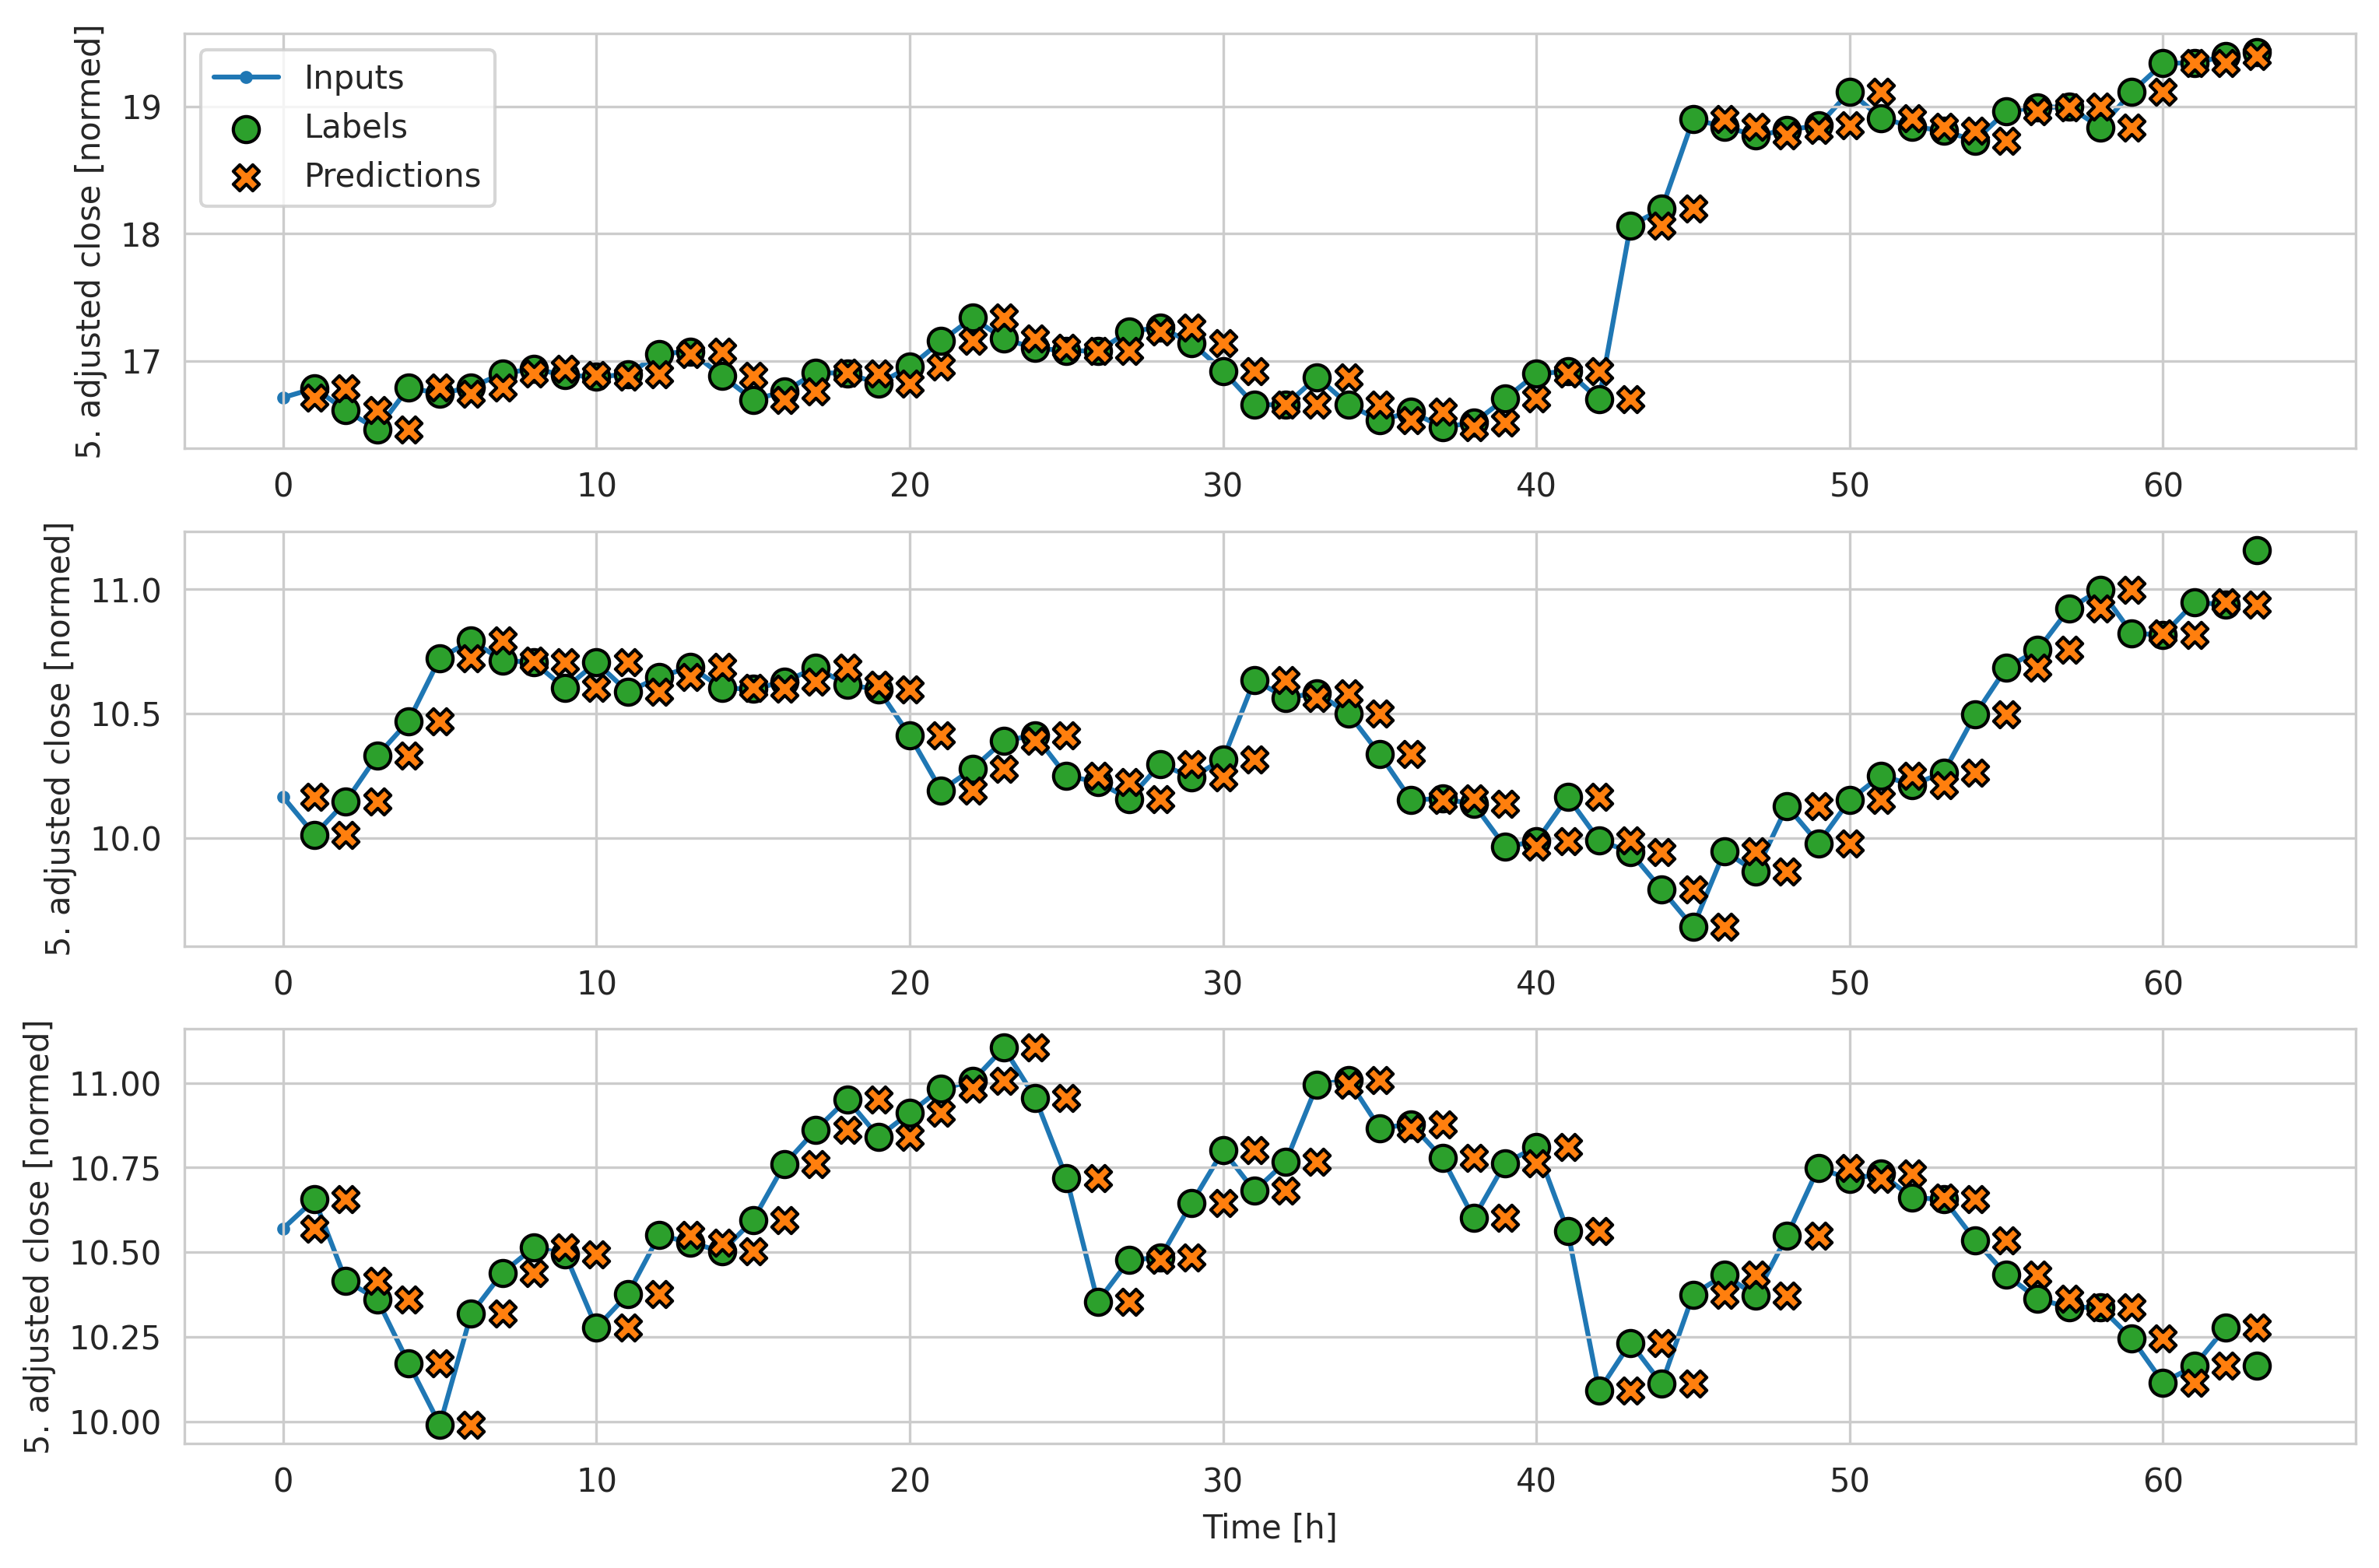

In [72]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 24 hours. This deserves some explanation:

- The blue `Inputs` line shows the input temperature at each time step. The model receives all features, this plot only shows the temperature.
- The green `Labels` dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
- The orange `Predictions` crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the `Labels`.

In [73]:
test_df["pred"] = test_df["5. adjusted close"].shift(1)

<ipython-input-73-08efa5e973ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["pred"] = test_df["5. adjusted close"].shift(1)


In [74]:
test_df

,5. adjusted close,pred
2820,119.818452,NaN
2821,119.281640,119.818452
2822,122.661568,119.281640
2823,121.816586,122.661568
2824,119.381049,121.816586
...,...,...
3059,165.120000,164.850000
3060,163.200000,165.120000
3061,166.560000,163.200000
3062,166.230000,166.560000


In [75]:
test_df.index = date_time[split_time+63:]

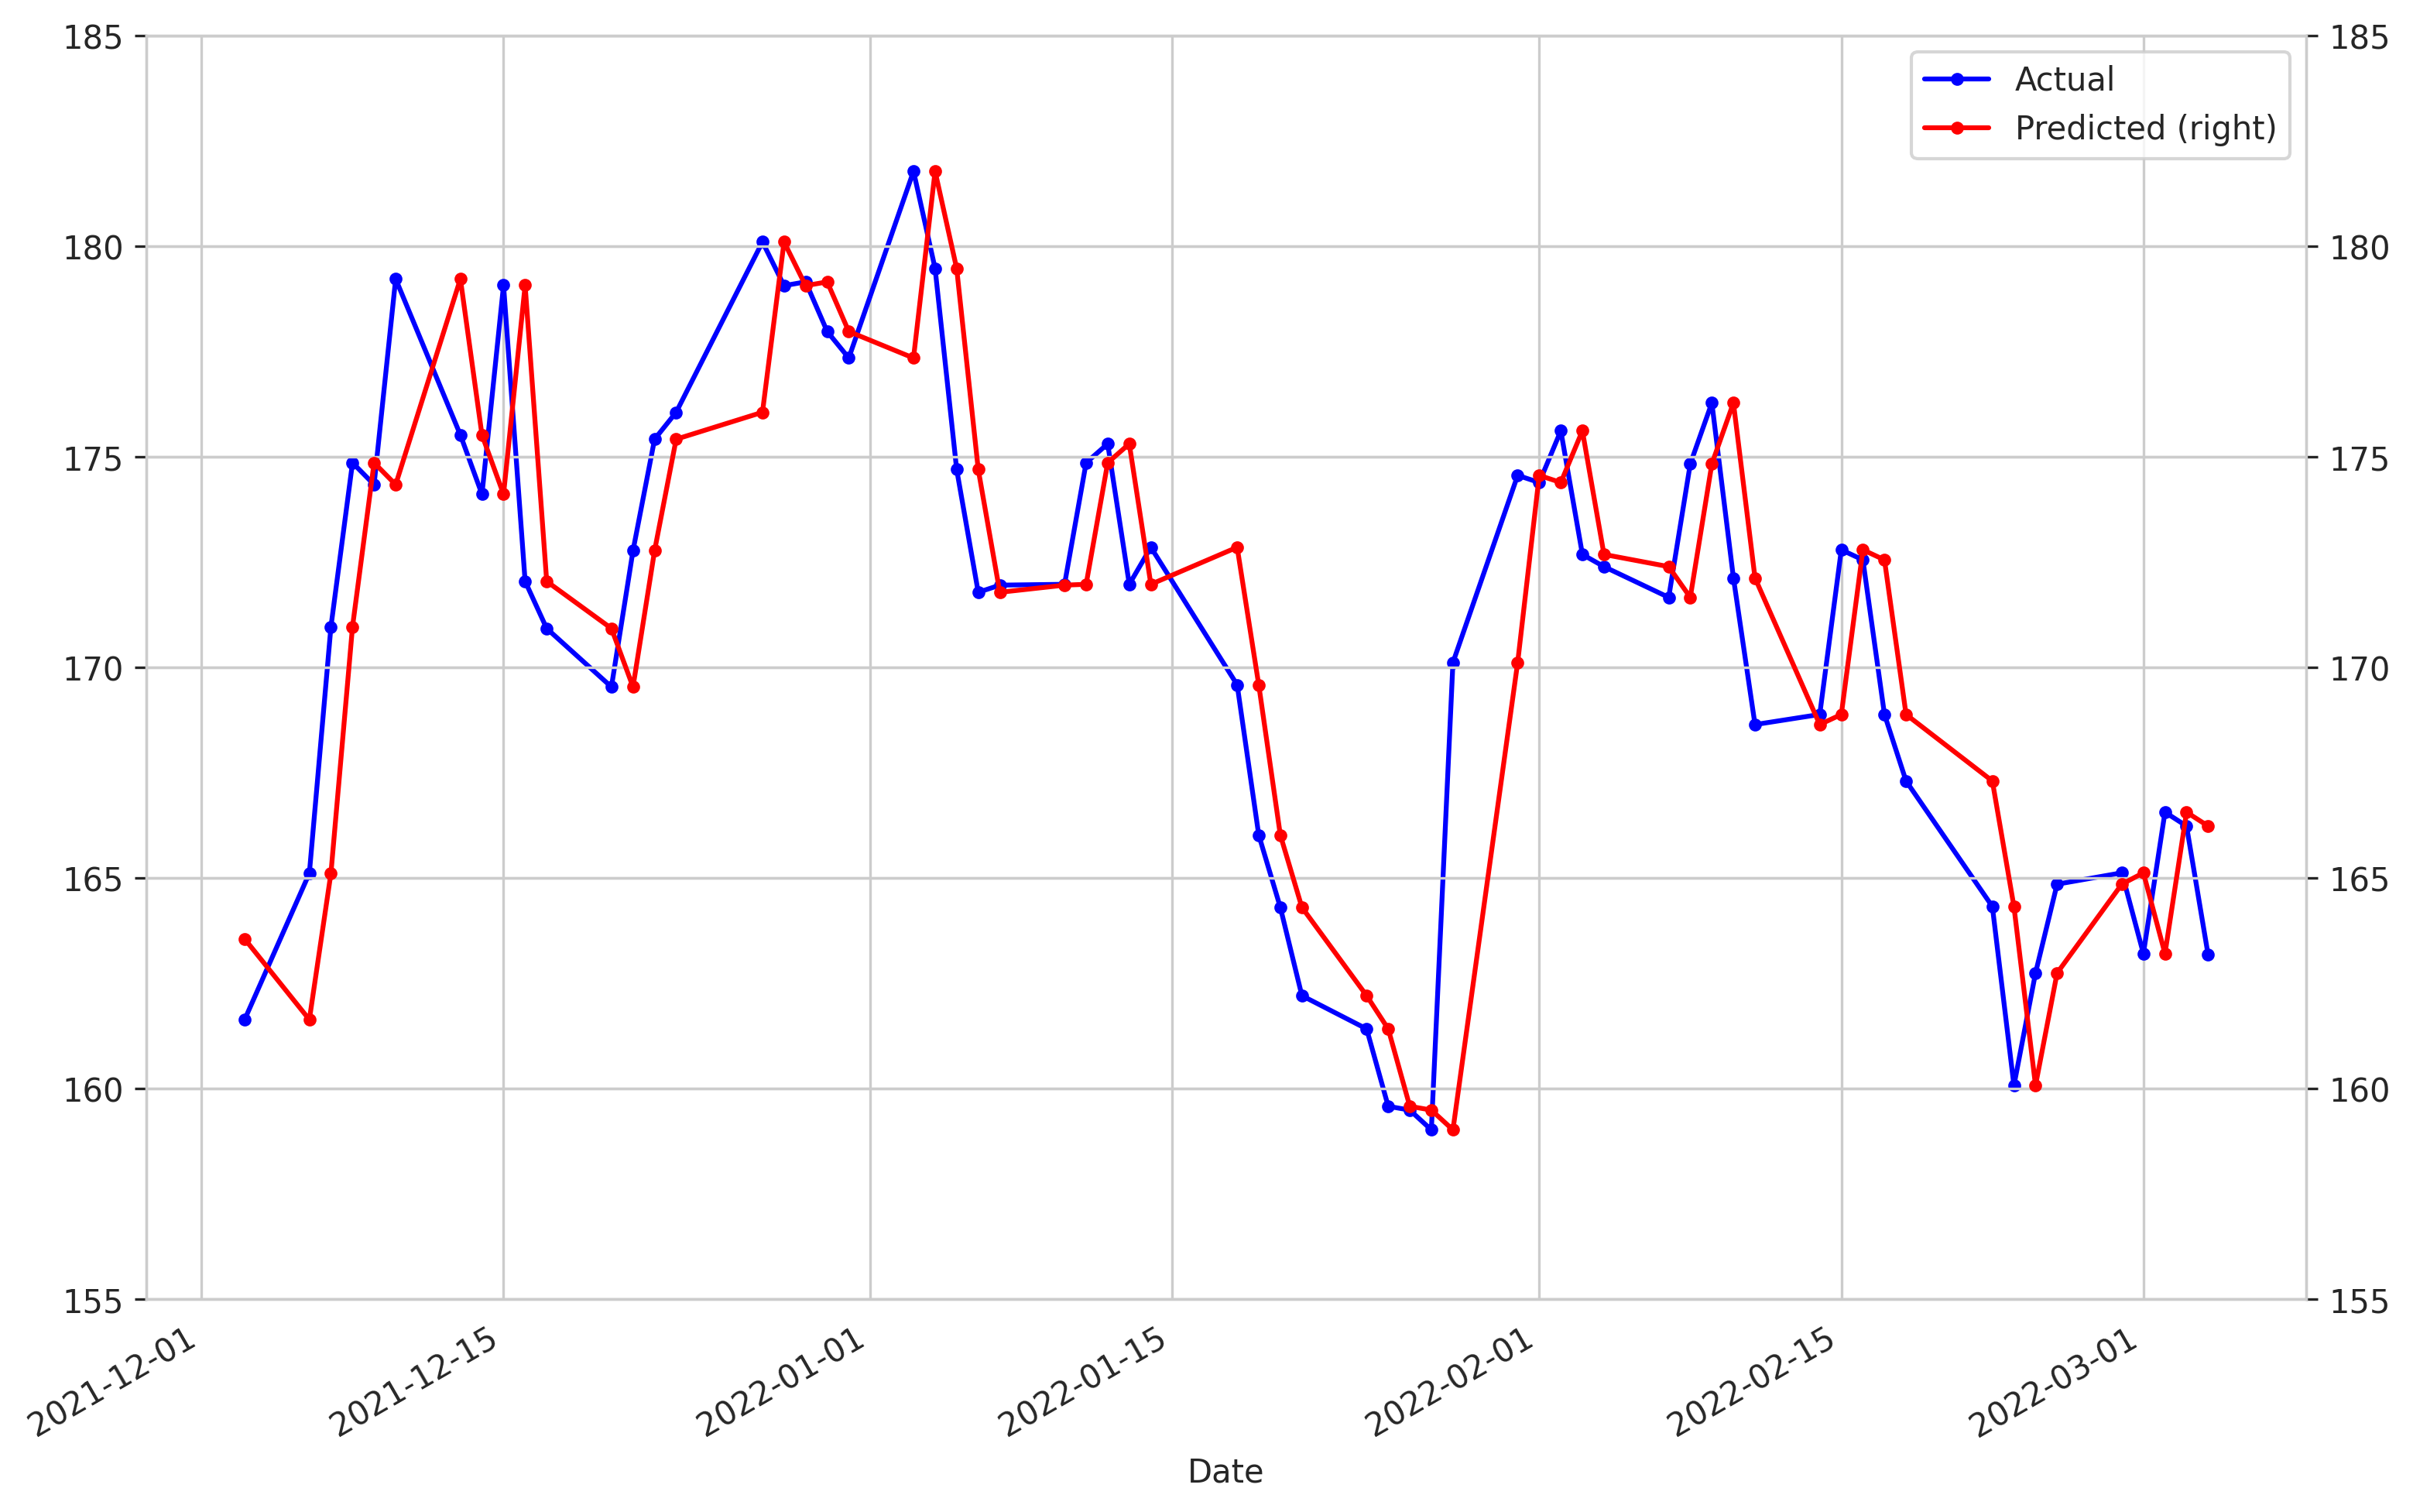

In [76]:
plt.figure(figsize=(12,8))

ax1 = test_df["5. adjusted close"][-63:].plot(color='blue', grid=True, secondary_y=False, label='Actual', marker='.')
ax2 = test_df["pred"][-63:].plot(color='red', grid=True, secondary_y=True, label='Predicted', marker='.')

a, b = 155, 185

ax1.set_ylim(a,b)
ax2.set_ylim(a,b)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax1.set_xlabel("Date")
plt.legend(h1+h2, l1+l2, loc=1)
plt.show()